# WSC Project - Data Analysis & NLP

In [1]:
# Standard library imports
import warnings
warnings.filterwarnings('ignore')
import ast
import re

# Data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP imports
import nltk
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
import json

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
import tiktoken
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# load and utils

In [2]:
ACTIONS = list(set(pd.read_csv("data/actions.csv")["parameter"]))
pseudo_df = pd.read_csv("data/pseudo_actions_labels_with_id.csv")[['sample_id', 'action_detected']]
transcripts_folds_df = pd.read_csv('data/transcripts_folds.csv')
features_df = transcripts_folds_df[['sample_id', 'Text', 'tokenized_text', 'events', 'actions_in_text', 'Label', 'fold1', 'fold2', 'fold3', 'fold4', 'fold5']]
# features_df = transcripts_folds_df[['sample_id', 'Text', 'tokenized_text', 'events', 'actions_in_text']]

expr_df = pseudo_df.merge(features_df, on='sample_id', how='inner').rename(columns={'action_detected': 'actions_pseudo_label', 'actions_in_text': 'actions_str_detected', 'Text': 'transcript_text'})
expr_df['actions_pseudo_label'] =  expr_df['actions_pseudo_label'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

with open('data/actions_processed_to_action.json', 'r') as f:
    actions_map = json.load(f)

inverse_actions_map = {v: k for k, v in actions_map.items()}
expr_df['actions_str_detected'] = expr_df['actions_str_detected'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
expr_df['actions_str_detected'] = expr_df['actions_str_detected'].apply(lambda actions: [inverse_actions_map.get(a, a) for a in actions])

# ML

In [5]:
augmented_texts_df = pd.read_csv('data/augmented_texts_processed.csv')[['sample_id', 'augmented_text', 'tokenized_augmented_text', 'action']]

def concat_augmentations_to_fold_df(fold_train_df):
    augmented_texts_train = augmented_texts_df[augmented_texts_df['sample_id'].isin(fold_train_df['sample_id'])]
    augmented_texts_train = augmented_texts_train.rename(columns={'augmented_text': 'transcript_text', 'action': 'actions_pseudo_label', 'tokenized_augmented_text': 'tokenized_text'})
    augmented_texts_train['actions_pseudo_label'] = augmented_texts_train['actions_pseudo_label'].apply(lambda x: [x])
    augmented_texts_train = augmented_texts_train.merge(
        fold_train_df.drop(['actions_pseudo_label', 'transcript_text', 'tokenized_text'], axis=1), 
        on='sample_id', 
        how='inner'
    )
    return pd.concat([fold_train_df, augmented_texts_train], ignore_index=True)

In [91]:

def tfidf_validation_prediction(train_df, test_df, text_col, predict_threshold=0.5):
    # Binary classification: predict train_df['Label'] (should be 0 or 1)
    y = train_df['Label'].values

    if text_col == 'tokenized_text_str':
        train_df['tokenized_text_str'] = train_df['tokenized_text'].apply(lambda x: ' '.join(ast.literal_eval(x)) if isinstance(x, str) else ' '.join(x))
        test_df['tokenized_text_str'] = test_df['tokenized_text'].apply(lambda x: ' '.join(ast.literal_eval(x)) if isinstance(x, str) else ' '.join(x))
    # else:
    #     train_df[text_col] = train_df[text_col].str.lower()
    #     test_df[text_col] = test_df[text_col].str.lower()

    train_df['tokenized_events_str'] = train_df['events'].apply(lambda x: ' '.join(['_'.join((w or '').split()) if w else '' for w in (ast.literal_eval(x) if isinstance(x, str) else x)]))
    test_df['tokenized_events_str'] = test_df['events'].apply(lambda x: ' '.join(['_'.join((w or '').split()) if w else '' for w in (ast.literal_eval(x) if isinstance(x, str) else x)]))

    train_df['action'] = train_df['actions_pseudo_label'].apply(lambda x: ' '.join(['_'.join((w or '').split()) if w else '' for w in (ast.literal_eval(x) if isinstance(x, str) else x)]))
    test_df['action'] = test_df['actions_pseudo_label'].apply(lambda x: ' '.join(['_'.join((w or '').split()) if w else '' for w in (ast.literal_eval(x) if isinstance(x, str) else x)]))
    
    get_text = FunctionTransformer(lambda X: X[text_col], validate=False)
    get_events = FunctionTransformer(lambda X: X['tokenized_events_str'], validate=False)
    get_action = FunctionTransformer(lambda X: X['action'], validate=False)
    
    sublinear_tf = True

    solver = 'liblinear'

    pipeline = Pipeline([
       ('features', FeatureUnion([
           ('word_tfidf_text', Pipeline([('sel', get_text), ('tfidf', TfidfVectorizer(ngram_range=(2,3), analyzer='word', sublinear_tf=sublinear_tf))])),
           ('char_tfidf_text', Pipeline([('sel', get_text), ('tfidf', TfidfVectorizer(ngram_range=(5,6), analyzer='char', sublinear_tf=sublinear_tf))])),
           ('word_tfidf_events', Pipeline([('sel', get_events), ('tfidf', TfidfVectorizer(ngram_range=(1,1), analyzer='word', sublinear_tf=sublinear_tf))])),
        #    ('word_tfidf_action', Pipeline([('sel', get_action), ('tfidf', TfidfVectorizer(ngram_range=(1,1), analyzer='word', sublinear_tf=sublinear_tf))])),
       ])),
        ('classifier', LogisticRegression(class_weight='balanced', solver=solver, max_iter=2000, C=1))
    ])
    X = train_df[[text_col, 'tokenized_events_str', 'action']]
    X_test = test_df[[text_col, 'tokenized_events_str', 'action']]
    pipeline.fit(X, y)
    predictions_proba = pipeline.predict_proba(X_test)[:, 1]
    return predictions_proba



In [79]:

# expr_df['events'].apply(
#     lambda x: ' '.join([
#         '_'.join((w or '').split()) if w else '' 
#         for w in (ast.literal_eval(x) if isinstance(x, str) else x)
#     ])
# )

## Validaiton sets



TFIDF + LR: 

Mean metrics across folds:
precision    0.768
recall       0.777
f1           0.770
pr_auc       0.888
dtype: float64


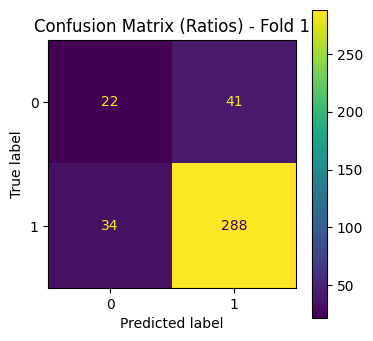

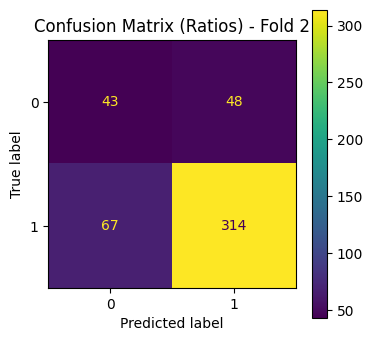

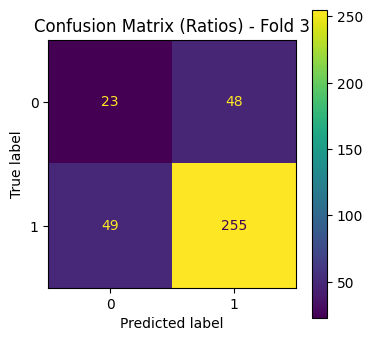

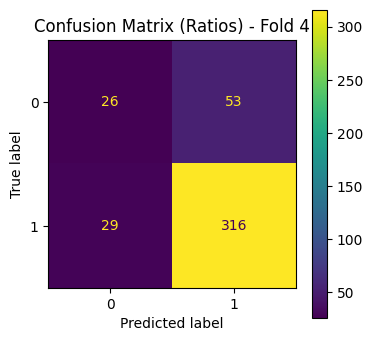

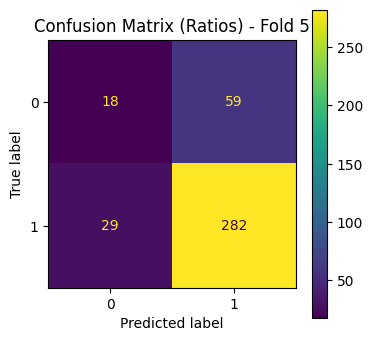

In [93]:
from sklearn.metrics import precision_recall_fscore_support

THRESHOLD = 0.5 # MultinomialNB
AUGMENT_DATA = True
# text_col_for_tfidf = 'transcript_text'
text_col_for_tfidf = 'tokenized_text_str'

df = expr_df.copy()

from sklearn.metrics import average_precision_score

def run_expr_predictions(inference_func, predict_threshold):
   metrics_dfs = []
   confusion_rows = []
   for fold_idx in range(1, 6):
      fold_col = f'fold{fold_idx}'
      fold_train_df = df[df[fold_col] == 'train']
      if AUGMENT_DATA:
         fold_train_df = concat_augmentations_to_fold_df(fold_train_df)
      fold_val_df = df[df[fold_col] == 'val']
      predictions_proba = tfidf_validation_prediction(fold_train_df, fold_val_df, text_col_for_tfidf, predict_threshold=predict_threshold)
      y_pred = (predictions_proba > predict_threshold).astype(int)

      y_true = fold_val_df['Label']
      
      precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
      pr_auc = average_precision_score(y_true, predictions_proba)
      cm = confusion_matrix(y_true, y_pred)
      confusion_rows.append({
         'fold': fold_idx,
         'cm': cm,
      })
      # Create a DataFrame for each fold's metrics
      metrics_df = pd.DataFrame([{
         'precision': precision,
         'recall': recall,
         'f1': f1,         'pr_auc': pr_auc,
         'fold': fold_idx
      }])
      metrics_dfs.append(metrics_df)

   metrics_df = pd.concat(metrics_dfs, ignore_index=True)
   confusion_df = pd.DataFrame(confusion_rows)
   return metrics_df, confusion_df

print('\n\nTFIDF + LR: ')
metrics_df, confusion_df = run_expr_predictions(inference_func=tfidf_validation_prediction, predict_threshold=THRESHOLD)
# print(metrics_df)
print("\nMean metrics across folds:")
print(metrics_df[['precision', 'recall', 'f1', 'pr_auc']].mean().round(3))

for idx, row in confusion_df.iterrows():
   cm = row['cm']
   disp = ConfusionMatrixDisplay(confusion_matrix=cm)
   fig, ax = plt.subplots(figsize=(4,4))
   disp.plot(ax=ax)
   plt.title(f"Confusion Matrix (Ratios) - Fold {row['fold']}")
   plt.show()

# display(confusion_df)







## test sets



TFIDF + LR: 

Mean metrics across folds:
precision    0.774
recall       0.790
f1           0.779
pr_auc       0.903
dtype: float64


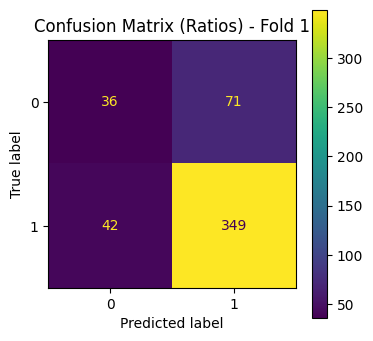

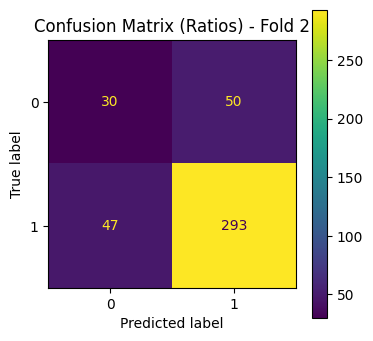

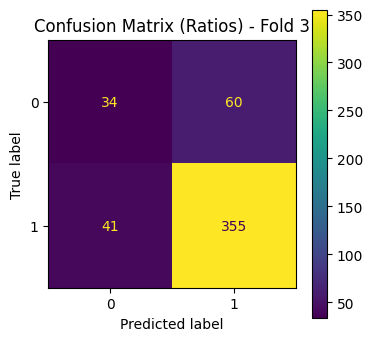

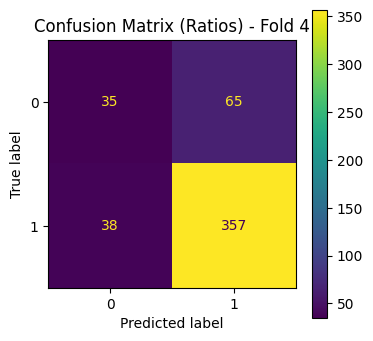

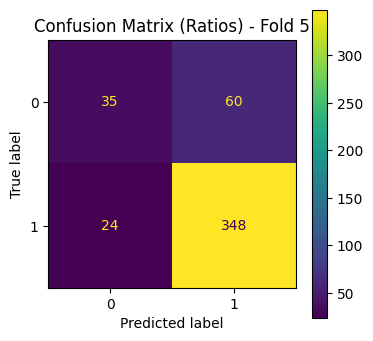

In [105]:
from sklearn.metrics import precision_recall_fscore_support

THRESHOLD = 0.5 # MultinomialNB
AUGMENT_DATA = True
# text_col_for_tfidf = 'transcript_text'
text_col_for_tfidf = 'tokenized_text_str'

df = expr_df.copy()

from sklearn.metrics import average_precision_score

def run_expr_predictions(inference_func, predict_threshold):
   metrics_dfs = []
   confusion_rows = []
   for fold_idx in range(1, 6):
      fold_col = f'fold{fold_idx}'
      fold_train_df = df[(df[fold_col] == 'train') | (df[fold_col] == 'val')]
      if AUGMENT_DATA:
         fold_train_df = concat_augmentations_to_fold_df(fold_train_df)
      fold_val_df = df[df[fold_col] == 'test']
      predictions_proba = tfidf_validation_prediction(fold_train_df, fold_val_df, text_col_for_tfidf, predict_threshold=predict_threshold)
      y_pred = (predictions_proba > predict_threshold).astype(int)

      y_true = fold_val_df['Label']
      
      precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
      pr_auc = average_precision_score(y_true, predictions_proba)
      cm = confusion_matrix(y_true, y_pred)
      confusion_rows.append({
         'fold': fold_idx,
         'cm': cm,
      })
      # Create a DataFrame for each fold's metrics
      metrics_df = pd.DataFrame([{
         'precision': precision,
         'recall': recall,
         'f1': f1,
         'pr_auc': pr_auc,
         'fold': fold_idx
      }])
      metrics_dfs.append(metrics_df)

   metrics_df = pd.concat(metrics_dfs, ignore_index=True)
   confusion_df = pd.DataFrame(confusion_rows)
   return metrics_df, confusion_df

print('\n\nTFIDF + LR: ')
metrics_df, confusion_df = run_expr_predictions(inference_func=tfidf_validation_prediction, predict_threshold=THRESHOLD)
# print(metrics_df)
print("\nMean metrics across folds:")
print(metrics_df[['precision', 'recall', 'f1', 'pr_auc']].mean().round(3))

for idx, row in confusion_df.iterrows():
   cm = row['cm']
   disp = ConfusionMatrixDisplay(confusion_matrix=cm)
   fig, ax = plt.subplots(figsize=(4,4))
   disp.plot(ax=ax)
   plt.title(f"Confusion Matrix (Ratios) - Fold {row['fold']}")
   plt.show()

# display(confusion_df)







In [100]:
metrics_df

,precision,recall,f1,pr_auc,fold
0,0.751580,0.773092,0.759365,0.892560,1
1,0.765729,0.769048,0.767348,0.883363,2
2,0.778286,0.793878,0.784705,0.907319,3
3,0.771927,0.791919,0.779120,0.912197,4
4,0.800107,0.820128,0.803255,0.921433,5
